# Noise2Void - 2D Example for time points between 390 and 399 - 2 Channels

Here, the volumetric images from camera CM02 have been flipped and translated. Next, the two images (CM02 and CM03) are used as two channels and denoised with N2V.

In [1]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.io import save_tiff_imagej_compatible
import glob
import copy

Using TensorFlow backend.


## Load the Network

In [2]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_2D_kellerLab_T390-399_2Channels'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


## Prediction
Here we will simply use the same data as during training and denoise it using our network.

## Load images from CM02

In [3]:
datagen = N2V_DataGenerator()

In [4]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs_CM02 = [imread(img) for img in filenames]

print(len(imgs_CM02))
print(imgs_CM02[0].shape)

10
(70, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs_CM03 = [imread(img) for img in filenames]

print(len(imgs_CM03))
print(imgs_CM03[0].shape)

10
(70, 896, 576)


## Combine imgs_CM02 and imgs_CM03

In [6]:
input_train=[]
for i in range(len(imgs_CM02)):
    combined=np.empty([imgs_CM02[0].shape[0], imgs_CM02[0].shape[1], imgs_CM02[0].shape[2], 2])
    combined[..., 0]=imgs_CM02[i]
    combined[..., 1]=imgs_CM03[i]
    input_train.append(combined)
print(len(input_train))
print(input_train[0].shape)

10
(70, 896, 576, 2)


## Delete the first 60 pixels from the x dimension

In [7]:
for i in range(len(input_train)):
    input_train[i]=input_train[i][..., 60:, :]
print(len(input_train))
print(input_train[0].shape)

10
(70, 896, 516, 2)


In [8]:
pred_train=copy.deepcopy(input_train)
for i in range(len(input_train)):
    for j in range(input_train[i].shape[0]):
        img=input_train[i][j, ...]
        result_image=model.predict(img, axes='YXC', n_tiles=(4,4,1))
        pred_train[i][j, ...]=result_image


100%|██████████| 16/16 [00:00<00:00, 77.24it/s]  


100%|██████████| 16/16 [00:00<00:00, 82.02it/s]  


100%|██████████| 16/16 [00:00<00:00, 79.69it/s]  


In [9]:
print(len(pred_train))
print(pred_train[0].shape)

10
(70, 896, 516, 2)


### Show results on training data...

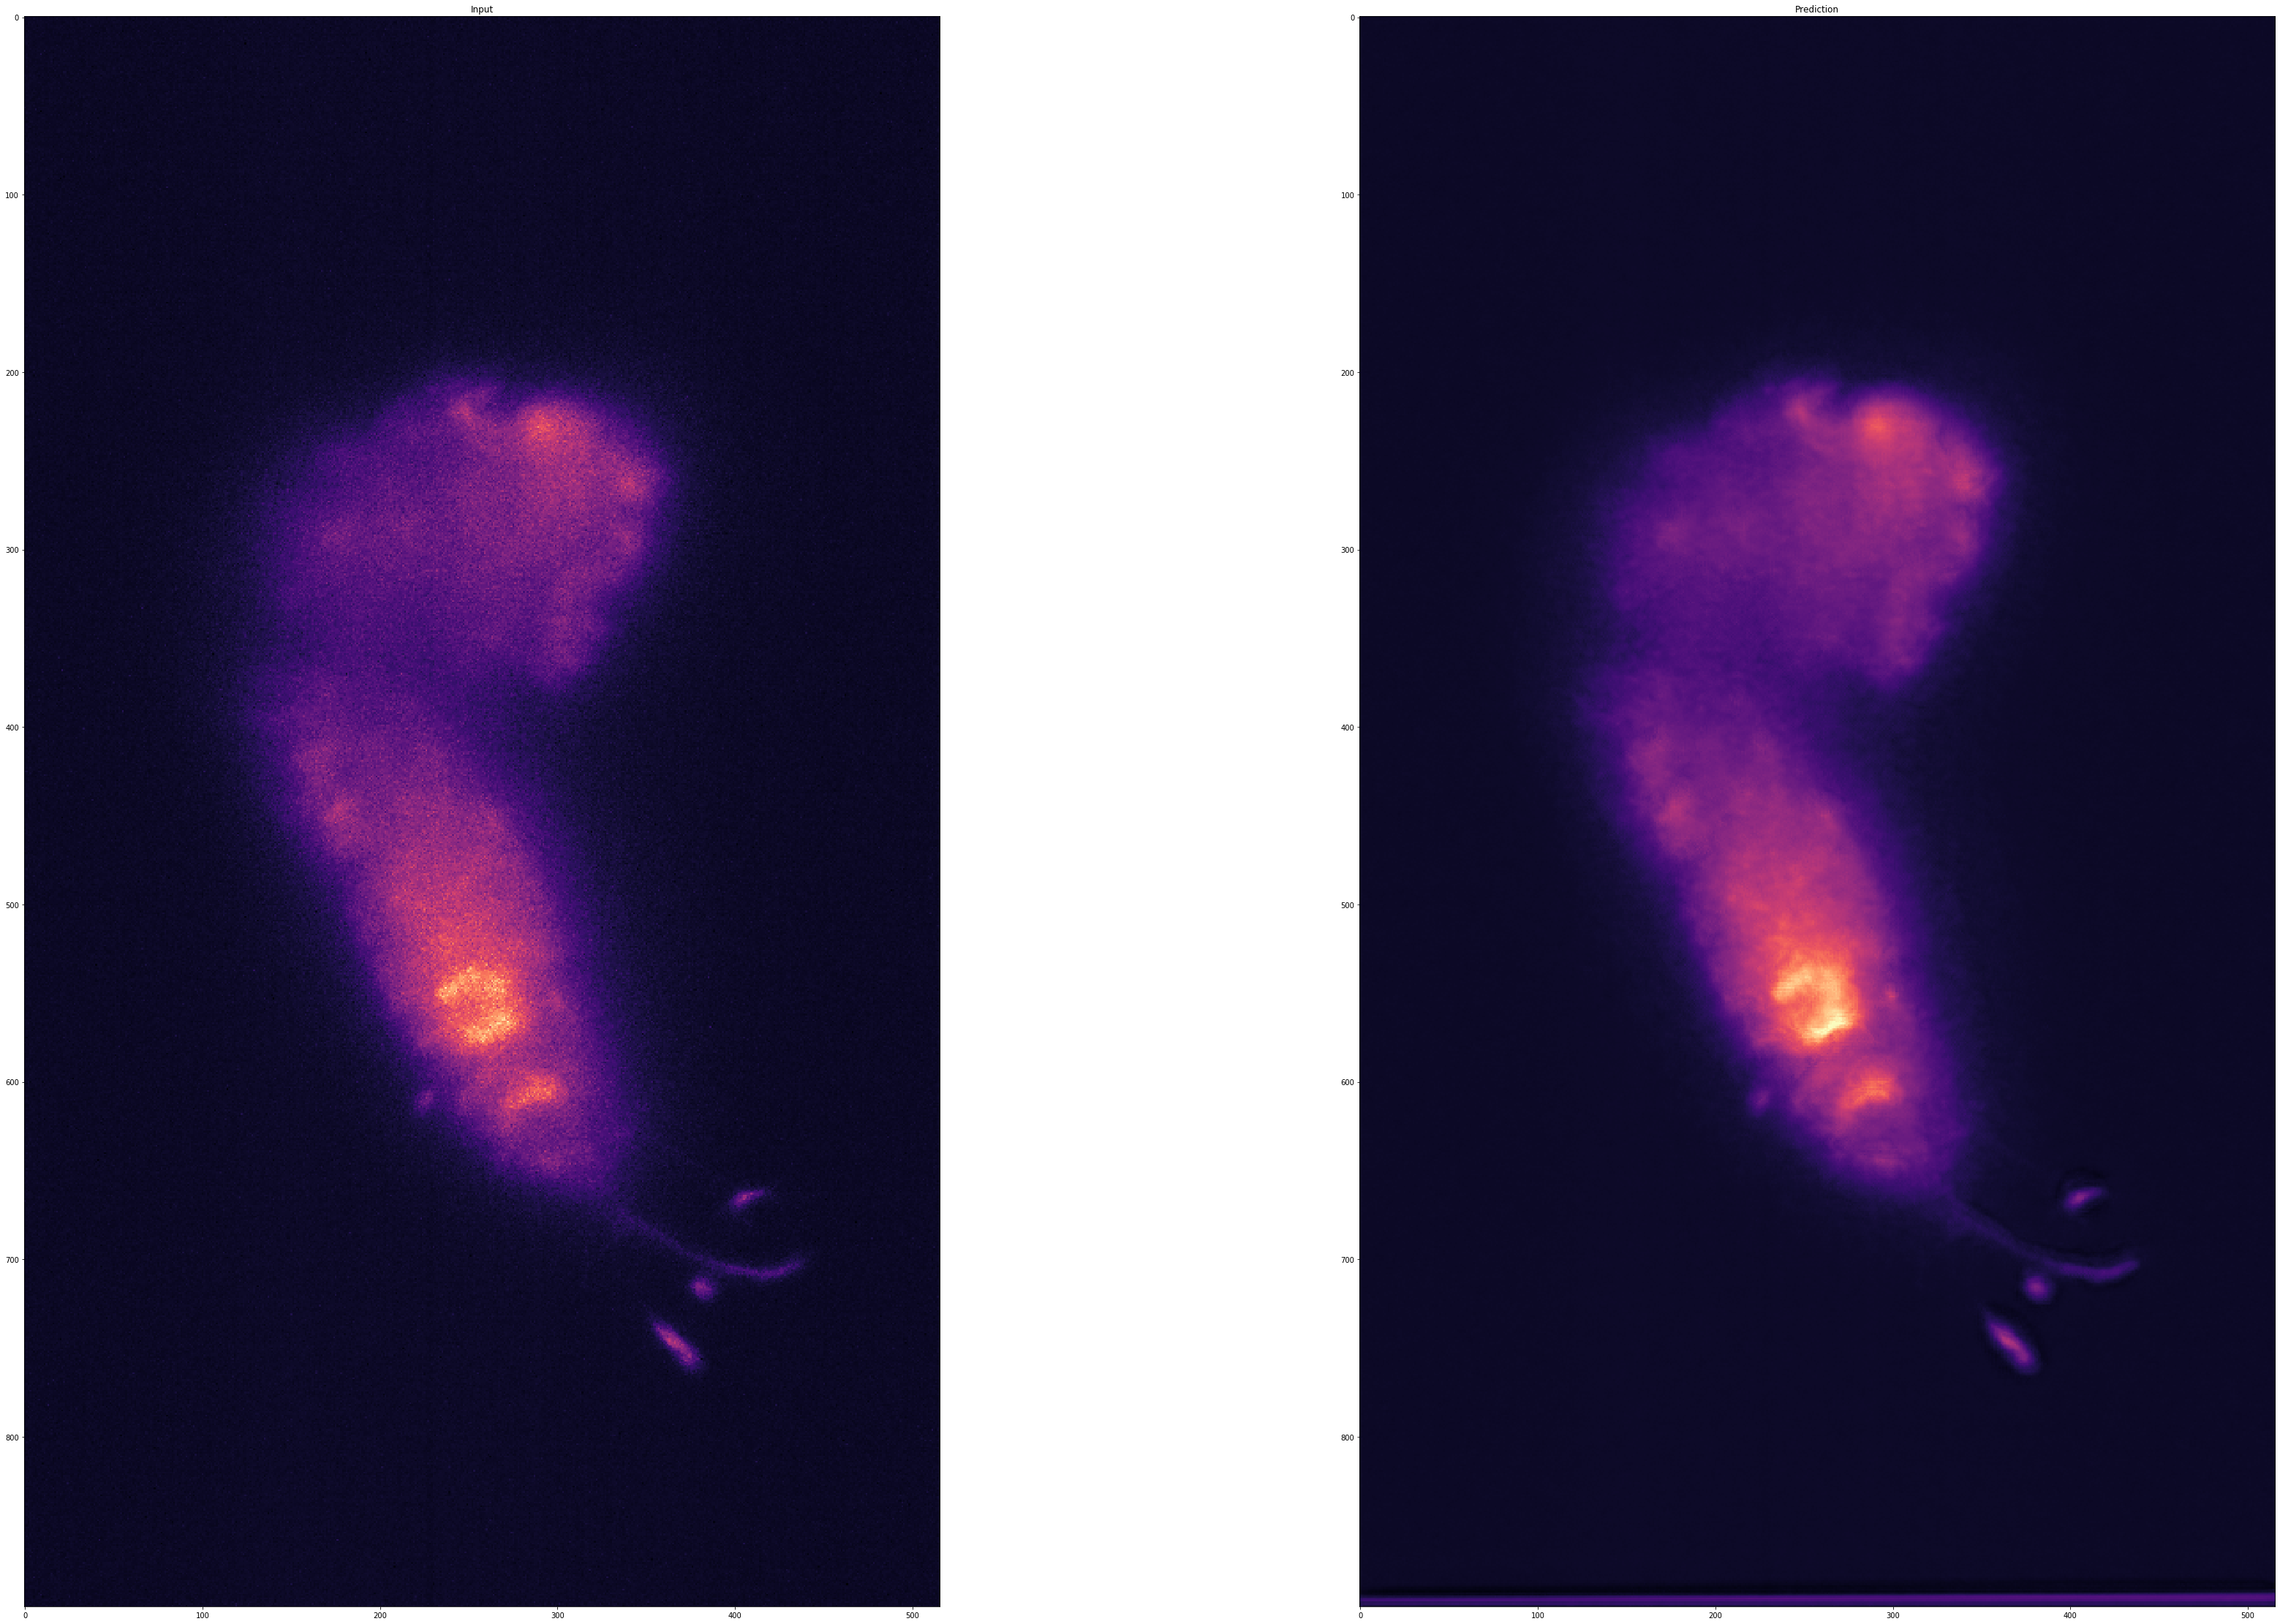

In [14]:
# Let's look at the results.
vmin=np.min(input_train[5][22, ..., 1])
vmax=np.max(input_train[5][22, ..., 1])
plt.figure(figsize=(60,40))
plt.subplot(1,2,1)
plt.imshow(input_train[5][22, ..., 1],cmap="magma", vmin=vmin, vmax=vmax)
plt.title('Input');

plt.subplot(1,2,2)
plt.imshow(pred_train[5][22, ..., 1],cmap="magma", vmin=vmin, vmax=vmax)
plt.title('Prediction');


## Reconstitute the images

In [15]:
for i in range(len(pred_train)):
    fileindex=390+i
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/N2V_390-399_2Channels/CM02/"+str(fileindex)+".tif",np.array(pred_train[i][..., 0], dtype='uint16'))
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/N2V_390-399_2Channels/CM03/"+str(fileindex)+".tif",np.array(pred_train[i][..., 1], dtype='uint16'))
